This is a test to explore working with a CFHT pointing history instead of OpSim pointing history. To do this quickly, and because I did not have a CFHT pointing history in sqlite format, I just worked directly with python. I used pandas to read the CSV pointing data from Megaprime (retrieved from http://www4.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/search/ - thank you CADC!) and select the r band only -- you could change that to select all bands or some other bandpass. Then I converted the pandas DataFrame to a numpy structured array, so that MAF could work with it. From there on, I'm simply working with the MAF classes. A lot of this is pretty quick and dirty in the current version .. it's a hack :) 

To avoid stuffing the git repo, I didn't put the cfht_pointings.csv file here. However, it is available at http://www.astro.washington.edu/users/lynnej/cfht/cfht_pointing.csv

As we work on MAF further, one of the things we'd like to do is make the output plots interactive. I think this is a good example where that would be very cool -- especially if you calculated (for example) the number of visits or total exposure time in different filters and then could flip back and forth between those .. or also used a pointing history from another telescope and could overlay the two. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
datafile = 'cfht_pointing.csv'

Read the data using pandas. Read only the columns that I think are useful. 

In [3]:
data = pd.read_csv(datafile, 
                   usecols=('Collection', 'RA (J2000.0)', 'Dec. (J2000.0)', 'Start Date', 
                            'Instrument', 'Int. Time', 'Filter'))

In [4]:
print "Retrieved ", len(data), "pointing records"
data[0:10]

Retrieved  137245 pointing records


,Collection,RA (J2000.0),Dec. (J2000.0),Start Date,Instrument,Int. Time,Filter
0,CFHT,49.900037,-0.770098,56189.611544,MegaPrime,85.049,r.MP9601
1,CFHT,87.342166,36.014333,55655.292345,MegaPrime,150.113,r.MP9601
2,CFHT,248.363126,-27.929907,56803.497558,MegaPrime,60.041,r.MP9601
3,CFHT,50.799997,-0.770098,56189.613086,MegaPrime,85.066,r.MP9601
4,CFHT,87.774668,15.014333,55655.295255,MegaPrime,150.094,r.MP9601
5,CFHT,51.700037,-0.770098,56189.614629,MegaPrime,85.066,r.MP9601
6,CFHT,88.207332,29.014363,55655.298164,MegaPrime,150.102,r.MP9601
7,CFHT,52.700037,-0.770098,56189.616172,MegaPrime,85.064,r.MP9601
8,CFHT,88.745248,12.014363,55655.301071,MegaPrime,150.099,r.MP9601
9,CFHT,282.562551,43.846563,55149.239857,MegaPrime,120.152,r.MP9601


I selected the CFHT pointings which used Megaprime only - let's just check that we only have megaprime instrument pointings here.

In [5]:
data.groupby('Instrument').count()

,Collection,RA (J2000.0),Dec. (J2000.0),Start Date,Int. Time,Filter
Instrument,,,,,,
MegaPrime,137245,137046,137046,137245,137243,137244


Add a column with RA/Dec in radians (as that's what MAF is assumes internally). Drop columns with Nans. Check what filters were available. 

In [6]:
mp = data.loc[data['Instrument'] == 'MegaPrime'].dropna()
mp['ra'] = mp['RA (J2000.0)'] * np.pi/180.0
mp['dec'] = mp['Dec. (J2000.0)'] * np.pi/180.0
print "After dropping nans, ", len(mp), "pointings available."
mp[0:5]

After dropping nans,  137043 pointings available.


,Collection,RA (J2000.0),Dec. (J2000.0),Start Date,Instrument,Int. Time,Filter,ra,dec
0,CFHT,49.900037,-0.770098,56189.611544,MegaPrime,85.049,r.MP9601,0.870920,-0.013441
1,CFHT,87.342166,36.014333,55655.292345,MegaPrime,150.113,r.MP9601,1.524408,0.628569
2,CFHT,248.363126,-27.929907,56803.497558,MegaPrime,60.041,r.MP9601,4.334754,-0.487469
3,CFHT,50.799997,-0.770098,56189.613086,MegaPrime,85.066,r.MP9601,0.886627,-0.013441
4,CFHT,87.774668,15.014333,55655.295255,MegaPrime,150.094,r.MP9601,1.531957,0.262050


In [7]:
mp.groupby('Filter').count()

,Collection,RA (J2000.0),Dec. (J2000.0),Start Date,Instrument,Int. Time,ra,dec
Filter,,,,,,,,
CN.MP7803,112,112,112,112,112,112,112,112
Ha.MP7605,650,650,650,650,650,650,650,650
HaOFF.MP7604,144,144,144,144,144,144,144,144
N393.MP1111,130,130,130,130,130,130,130,130
OIII.MP7504,126,126,126,126,126,126,126,126
TiO.MP7701,150,150,150,150,150,150,150,150
g.MP9401,38006,38006,38006,38006,38006,38006,38006,38006
i.MP9701,10383,10383,10383,10383,10383,10383,10383,10383
i.MP9702,13938,13938,13938,13938,13938,13938,13938,13938


Do our "select" to pull out data in r or i band only, and convert to a numpy structured array for MAF. 

In [9]:
simdata = mp.query("Filter=='r.MP9601' or Filter=='i.MP9702' or Filter=='i.MP9701'")

simdata = simdata.to_records()
print simdata.shape
print simdata.dtype.names
print np.unique(simdata['Filter'])

(71846,)
('index', 'Collection', 'RA (J2000.0)', 'Dec. (J2000.0)', 'Start Date', 'Instrument', 'Int. Time', 'Filter', 'ra', 'dec')
['i.MP9701' 'i.MP9702' 'r.MP9601']


Now import our MAF stuff and get started setting up metrics, the slicer (we'll use a healpix slicer to look at the distribution on a healpix grid) and running the metrics.

In [10]:
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles

ImportError: dlopen(/Users/lynnej/lsst/DarwinX86/obs_lsstSim/10.0-2-gc584ed1+13/python/lsst/obs/lsstSim/_sensorLib.so, 10): Symbol not found: __ZNK4lsst3afw4geom7Functor7inverseEddj
  Referenced from: /Users/lynnej/lsst/DarwinX86/obs_lsstSim/10.0-2-gc584ed1+13/lib/libobs_lsstSim.dylib
  Expected in: /Users/lynnej/lsst/DarwinX86/afw/master-g7d0203e41d/lib/libafw.dylib
 in /Users/lynnej/lsst/DarwinX86/obs_lsstSim/10.0-2-gc584ed1+13/lib/libobs_lsstSim.dylib

Set up the slicer -- note this is where we should also specify 'radius' which pretty much translates to the radius of the field of view. The default value is 1.75 deg, appropriate for LSST. For Megaprime, it should be closer to 1.0 deg across (radius 0.5). Which means I should bump up the healpix grid resolution as well to avoid just missing a field. That'll make the metric calculation run slower.

In [10]:
nside = 128
radius = 0.5
slicer = slicers.HealpixSlicer(nside=nside, spatialkey1='ra', spatialkey2='dec', radius=radius)
slicer.setupSlicer(simdata)

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


In [11]:
m1 = metrics.CountMetric(col='Start Date')
m2 = metrics.SumMetric(col='Int. Time')

In [12]:
sm = sliceMetrics.RunSliceMetric(useResultsDb=False)
sm.setSlicer(slicer)
sm.setMetrics([m1, m2])

Actually do the metric calculation. This step takes a noticeable amount of time (depends on healpix resolution) on my mac. With a nside=512, was about 1.5 min, but with nside=256 was less than 30 s.

In [13]:
sm.runSlices(simdata, simDataName='cfht', metadata='nside = %d radius = %.2f' %(nside, radius))

In [14]:
# I'll just write that out to disk ...
sm.writeAll()

Okay, let's make some plots. I'm going straight down into the slicer plotting method here. You could also use sm.plotMetric(iid) to get all of the plots from the slicer, including the histogram and power spectrum.

Count Start Date


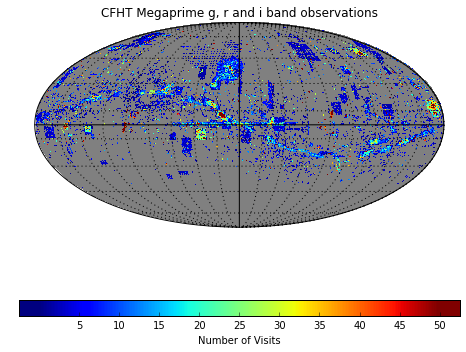

In [15]:
iid = 0
# Just check that we're plotting the thing we thought ... the RunSliceMetric stores the metric data, 
# along with metric name and other metadata in dictionaries keyed by 'iid'
print sm.metricNames[iid]
slicer.plotSkyMap(sm.metricValues[iid], colorMin=0, colorMax=50, cbarFormat='%d', xsize=1600,
                  xlabel='Number of Visits', title='CFHT Megaprime g, r and i band observations')
plt.savefig('cfht_visits.png', format='png', dpi=600)

Let's zoom in! The slicer doesn't have a built-in function to zoom in YET .. so I'll just hack deeper to healpy and use the plotting functions there directly. (plotSkyMap uses this as well, but only the zoomed-out mollview).  I'm a little suspicious of the wallpaper-style areas .. I think those are probably supposed to be contiguous fields?
Also you can see from the 'rot' that there's a problem with our translation from ra/dec to lon/lat (decs are 'upside down' but it'll be fixed soon).

In [16]:
import healpy as hp

33.3963137547 170.603686245 -92.136333406 48.136333406
The interval between parallels is 20.00 deg 0.00'.
The interval between meridians is 20.00 deg 0.00'.


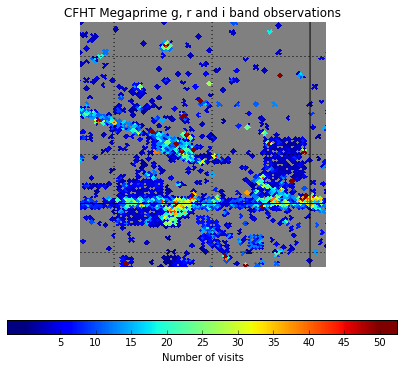

In [20]:
lon_cen = 22
lat_cen = 12
size = 50.0
lonra = [lon_cen - size/2.0, lon_cen + size/2.0]
latra = [lat_cen - size/2.0, lat_cen + size/2.0]
hp.cartview(map=sm.metricValues[iid], rot=(0, 0, 180), xsize=1600,
            lonra = lonra, latra = latra, flip='astro',
            title='CFHT Megaprime g, r and i band observations',
            cbar=False, min=0, max=50)
# Add our own colorbar
ax = plt.gca()
im = ax.get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, orientation='horizontal',
                  extend='both', extendrect=True, format='%d')
cb.set_label('Number of visits')
hp.graticule(dpar=20, dmer=20)

78.1084366309 101.891563369 -11.8915633691 11.8915633691
The interval between parallels is 20.00 deg 0.00'.
The interval between meridians is 20.00 deg 0.00'.


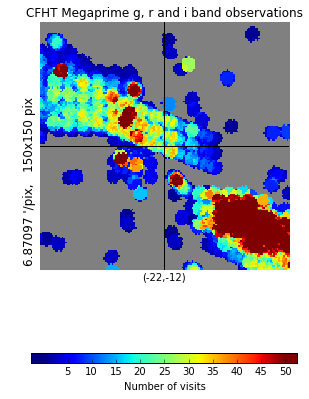

In [28]:
lon_cen = 22
lat_cen = 12
resolution = hp.nside2resol(nside, arcmin=True)
hp.gnomview(map=sm.metricValues[iid], rot=(-lon_cen, -lat_cen, 180), 
            reso=resolution, flip='astro', xsize=150,
            title='CFHT Megaprime g, r and i band observations',
            cbar=False, min=0, max=50)
# Add our own colorbar
ax = plt.gca()
im = ax.get_images()[0]
cb = plt.colorbar(im, shrink=0.75, aspect=25, orientation='horizontal',
                  extend='both', extendrect=True, format='%d')
cb.set_label('Number of visits')
hp.graticule(dpar=20, dmer=20)

Sum Int. Time


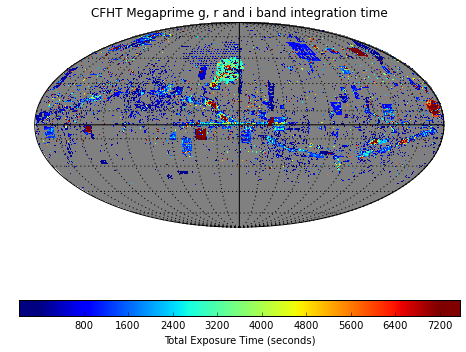

In [29]:
iid = 1
print sm.metricNames[iid]
slicer.plotSkyMap(sm.metricValues[iid], colorMin=0, colorMax=7200, cbarFormat='%.0f', 
                  xlabel='Total Exposure Time (seconds)', title='CFHT Megaprime g, r and i band integration time')
plt.savefig('cfht_time.png', format='png')

So the first version of this I made, I only used data after 2010. It's interesting that some of the sky coverage is noticeably different! I should make a movie ... 